In [3]:
import tfia_helper as tfia #metodos de ayuda para procesar datos

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from sklearn.model_selection import train_test_split

from keras import Input
from keras import layers
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LayerNormalization
from keras.layers import ConvLSTM1D
from keras.layers import Conv1DTranspose
from keras.layers import Flatten
from keras.layers import Dropout
# https://keras.io/examples/timeseries/timeseries_anomaly_detection/

In [4]:
#Usar el CPU en vez del GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print(tf.config.list_physical_devices('GPU'))

[]


In [5]:
plt.style.use('ggplot')

In [6]:
#Constantes
output_path = 'C:\\Git\\ProyectoRaspberry\\ModelosEntrenados\\'

In [8]:
normal_data_path = 'D:\\UCR\\TFIA\\Python\\Datos\\normal_completo.csv'
normal_data = np.genfromtxt(normal_data_path, delimiter=',')

In [9]:
data = normal_data.reshape(256, 4096, 3) # particiones, pasos, características

In [10]:
#Enconder
model = Sequential()
model.add(Conv1D(64,32, activation='relu', padding='same', strides=2, input_shape=data.shape[1:], name='Entrada_Encoder'))
model.add(Conv1D(32,16, activation='relu', padding='same', strides=2, name='Salida_Encoder'))
#Decoder
model.add(Conv1DTranspose(32,16, activation='relu',padding='same', strides=2, name='Entrada_Decoder'))
model.add(Conv1DTranspose(64,32, activation='relu',padding='same', strides=2))
model.add(Conv1DTranspose(data.shape[2],32,padding='same', name='Salida_Decoder'))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
history = model.fit(data, data, validation_split=0.2, epochs=100, callbacks=[callback], verbose=0)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Entrada_Encoder (Conv1D)    (None, 2048, 64)          6208      
                                                                 
 Salida_Encoder (Conv1D)     (None, 1024, 32)          32800     
                                                                 
 Entrada_Decoder (Conv1DTran  (None, 2048, 32)         16416     
 spose)                                                          
                                                                 
 conv1d_transpose (Conv1DTra  (None, 4096, 64)         65600     
 nspose)                                                         
                                                                 
 Salida_Decoder (Conv1DTrans  (None, 4096, 3)          6147      
 pose)                                                           
                                                        

In [13]:
# Guardar el modelo
tfia.guardar_modelo(model, output_path, 'detector_anomalias_CONV1D')

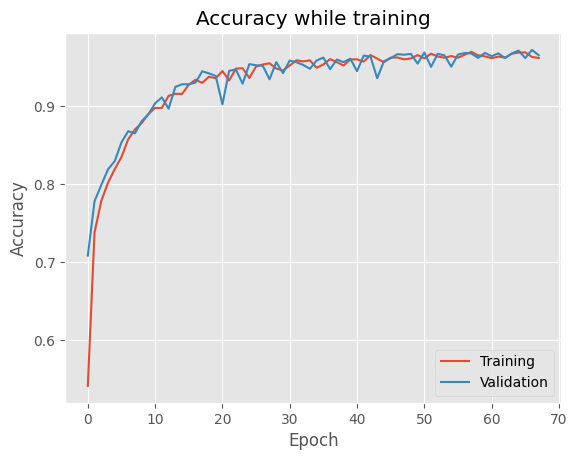

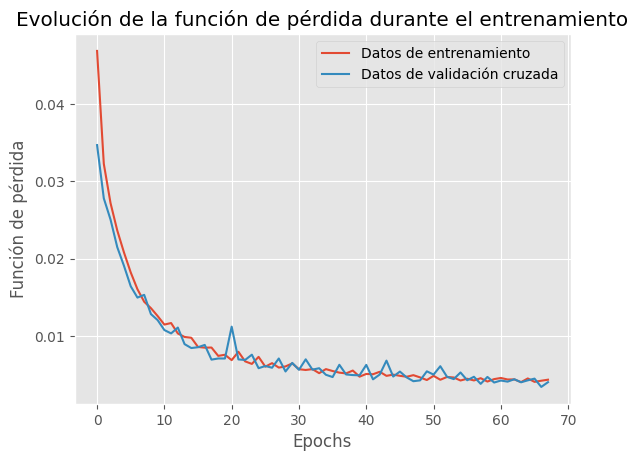

In [14]:
#Plots
plt.figure(1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy while training")
plt.legend()

plt.figure(2)
plt.plot(history.history['loss'], label='Datos de entrenamiento')
plt.plot(history.history['val_loss'], label='Datos de validación cruzada')
plt.xlabel("Epochs")
plt.ylabel("Función de pérdida")
plt.title("Evolución de la función de pérdida durante el entrenamiento")
plt.legend()

In [15]:
prediccion = model.predict(data)

8/8 [==============================] - 1s 106ms/step


In [16]:
error = np.mean(np.abs(prediccion-data) , axis=1)

In [17]:
error_distribucion = error.reshape(error.shape[0]*error.shape[1])

Text(0.5, 0, 'Tiempo (s)')

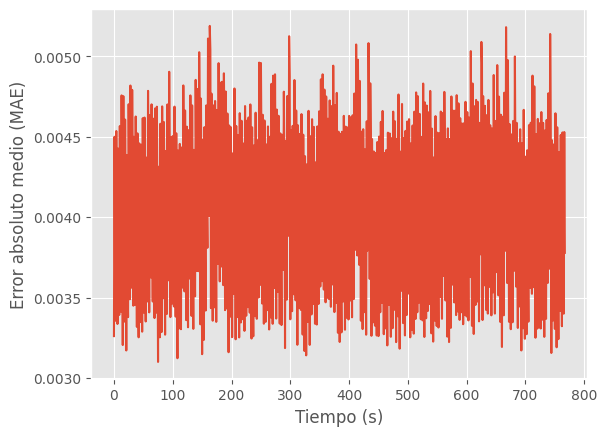

In [18]:
plt.plot(error_distribucion)
plt.ylabel('Error absoluto medio (MAE)')
plt.xlabel('Tiempo (s)')

Text(0, 0.5, 'Muestras')

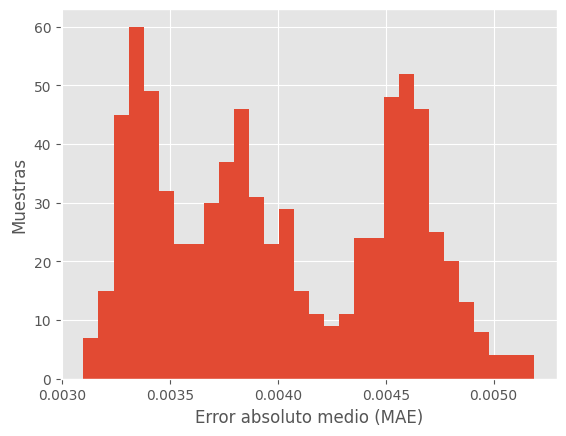

In [19]:
plt.hist(error_distribucion,bins=30)
plt.xlabel('Error absoluto medio (MAE)')
plt.ylabel('Muestras')
# plt.plot([0.01,0.01],[0,160], color='black')

In [21]:
path_prueba = 'D:\\UCR\\TFIA\\Python\\Datos\\prueba_completo.csv'

In [22]:
data_prueba = np.genfromtxt(path_prueba, delimiter=',')

In [23]:
data_prueba = data_prueba.reshape(256, 4096, 3)

In [24]:
detector_prueba = model.predict(data_prueba)

8/8 [==============================] - 1s 104ms/step


In [25]:
error = np.mean(np.abs(detector_prueba-data) , axis=1)
error_distribucion_prueba = error.reshape(error.shape[0]*error.shape[1])

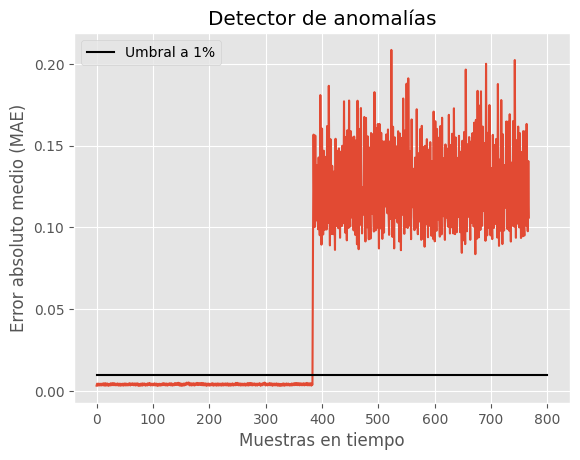

In [26]:
plt.plot(error_distribucion_prueba)
plt.plot([0,800],[0.01,0.01], color='black', label='Umbral a 1%')
plt.xlabel("Muestras en tiempo")
plt.ylabel("Error absoluto medio (MAE)")
plt.title("Detector de anomalías")
plt.legend()

Text(0.5, 0, 'Pasos en tiempo')

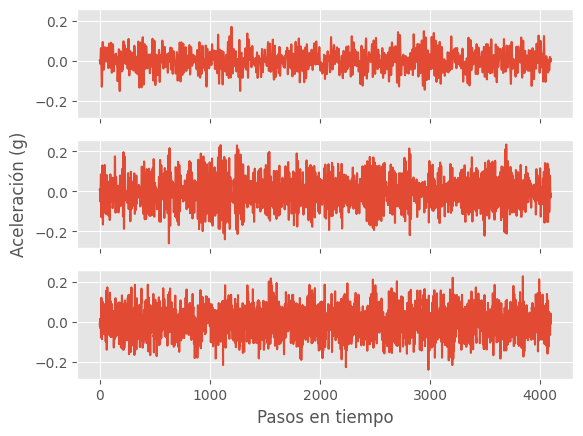

In [27]:
fig, axs = plt.subplots(3, sharex=True, sharey=True)
axs[0].plot(prediccion[1,:,0][0:4096])
axs[1].plot(prediccion[1,:,1][0:4096])
axs[2].plot(prediccion[1,:,2][0:4096])
axs[1].set_ylabel('Aceleración (g)')
axs[2].set_xlabel('Pasos en tiempo')

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model = model)

In [29]:
model_tflite = converter.convert()
open(output_path+'detector_anomalias.tflite', 'wb').write(model_tflite)

INFO:tensorflow:Assets written to: C:\Users\luisc\AppData\Local\Temp\tmpx_420g6u\assets


INFO:tensorflow:Assets written to: C:\Users\luisc\AppData\Local\Temp\tmpx_420g6u\assets


519488

In [31]:
data_prueba.shape

(256, 4096, 3)

In [34]:
np.abs(detector_prueba-data)

array([[[0.027866  , 0.07151812, 0.06586504],
        [0.01277284, 0.10848734, 0.0609749 ],
        [0.00827276, 0.10615142, 0.12578301],
        ...,
        [0.01637381, 0.06662748, 0.01754607],
        [0.02202937, 0.07605032, 0.00807681],
        [0.03689701, 0.05833732, 0.00921188]],

       [[0.04256359, 0.04185455, 0.08085221],
        [0.05432323, 0.0116956 , 0.05143139],
        [0.05460928, 0.00875666, 0.01305105],
        ...,
        [0.00184259, 0.00229793, 0.04891197],
        [0.01514872, 0.01743924, 0.10141308],
        [0.0445855 , 0.00275117, 0.0143464 ]],

       [[0.06062311, 0.03032477, 0.01675185],
        [0.07625205, 0.03845366, 0.01514991],
        [0.08042445, 0.03651643, 0.03718038],
        ...,
        [0.01528589, 0.00764396, 0.0635325 ],
        [0.00015927, 0.00663402, 0.08836139],
        [0.01696543, 0.02563007, 0.06816171]],

       ...,

       [[0.050618  , 0.03387132, 0.04110902],
        [0.09907406, 0.05772367, 0.00984592],
        [0.10658983, 0

In [40]:
len(data_prueba[2,:,1])

4096

In [48]:
error

array([[0.00326013, 0.00449959, 0.00354312],
       [0.00335547, 0.00453528, 0.00384591],
       [0.00333549, 0.0044262 , 0.00381589],
       [0.00339163, 0.00456622, 0.00390298],
       [0.00341234, 0.00475688, 0.00404208],
       [0.00320461, 0.00475222, 0.00381852],
       [0.00335008, 0.00460652, 0.00390386],
       [0.00317085, 0.00438643, 0.00362318],
       [0.00337815, 0.00470183, 0.00404483],
       [0.00348915, 0.00481815, 0.00425772],
       [0.00356084, 0.00479091, 0.00425763],
       [0.00344929, 0.00449965, 0.0040268 ],
       [0.00345523, 0.00462547, 0.00390928],
       [0.00331743, 0.00452094, 0.00359693],
       [0.00325259, 0.0044584 , 0.0038123 ],
       [0.00334707, 0.00445068, 0.00377098],
       [0.0032876 , 0.00461506, 0.0038804 ],
       [0.00340551, 0.00461906, 0.00385281],
       [0.00335112, 0.00437025, 0.00380259],
       [0.00347554, 0.00478484, 0.0041172 ],
       [0.0034077 , 0.00463485, 0.00382949],
       [0.00362457, 0.00470112, 0.00398121],
       [0.

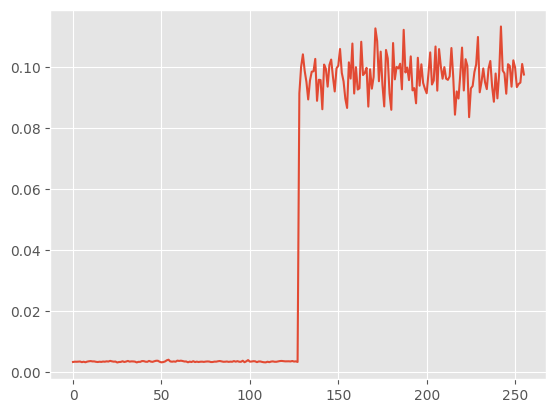

In [55]:
plt.plot(error[:,0])

In [58]:
error[0,0] > 0.02

False

In [70]:
test = np.array(np.random.rand(256,4096,3), dtype=np.float32)

In [76]:
test[0,:,:].shape

(4096, 3)

In [62]:
interpreter = tf.lite.Interpreter(model_path="C:\\Git\\ProyectoRaspberry\\ModelosEntrenados\\detector_anomalias.tflite")

In [63]:
interpreter.allocate_tensors()

In [64]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [74]:
input_details[0]['shape']

array([   1, 4096,    3])

In [77]:
interpreter.set_tensor(0, test[0,:,:].reshape(1,4096,3))

In [78]:
interpreter.invoke()

In [79]:
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[[ 0.02343127 -0.08696222 -0.1260761 ]
  [-0.05521541 -0.01318262 -0.02630124]
  [ 0.00318257 -0.08559819 -0.02117505]
  ...
  [-0.07853793 -0.10947291 -0.01310634]
  [-0.04800851 -0.08980206  0.0719239 ]
  [-0.13503468  0.03187737 -0.01245364]]]


In [80]:
output_data.shape

(1, 4096, 3)

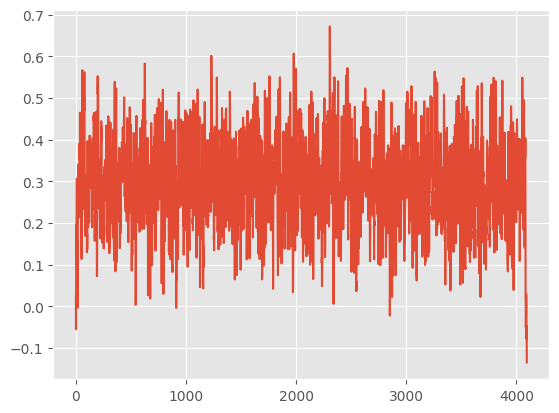

In [83]:
plt.plot(output_data[0,:,0])